# Violent movie finder model 

So far, we have cleaned the data and performed sentiment analysis as well as a violent word count analysis. Our objective is to categorize the movies on a scale from non-violent to violent.

Our approach will be to build a model that labels the dataset using various features.


## Labeling the Data
Since labeled data is required for analysis, we manually labeled a subset of the dataset. We divided part of the data among team members and labeled each movie plot based on a categorical scale:
<ul>
    <li><b>-1</b> : non-violent movies</li>
    <li><b>0</b> : possibly slightly violent or uncertain</li>
    <li><b>1</b> : definitely violent movies</li>
</ul>
To assess the subjectivity of the labeling process, we had some plots labeled multiple times by external participants.

## Model
For simplicity, we chose to perform a logistic regression using several selected features.

## Features
The selected feature set includes:
<ul>
    <li><b>Word Count Features</b>
        <ul> 
            <li>Count of physically violent words</li> 
            <li>Count of psychologically violent words</li> 
            <li>Density of physically violent words</li> 
            <li>Density of psychologically violent words</li>
        </ul>
    </li>
    <li><b>Sentimental Analysis Features</b>
       <ul>
           <li>Sadness</li>
           <li>Joy</li>
           <li>Love</li>
           <li>Anger</li>
           <li>Surprise</li>
       </ul>
    </li>
</ul>


## Dataset
<ul>
    <li><b>Training and Testing Data</b> <br/> Given the limited number of labeled plots available, we will use most of the labeled items for the training set. We will keep five plots as the testing set to evaluate the model (alternatively, we may use the entire dataset and assess labeling quality across the final labeled set) </li>
    <li><b>Final Dataset</b>  <br/> We will apply the model to label the entire dataset and review the quality of the labels.</li>
</ul>


### Imports

In [76]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LinearRegression,Ridge, LogisticRegression

%matplotlib inline

In [2]:
# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../data/"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = '../../data/RAW/'
clean = '../../data/CLEAN'

## Load and prepare the data

In [3]:
#load the data
data_loader = DataLoader(raw,clean)
MovieData,DataTest = data_loader.data_for_violent_model()
MovieData.head()

,name,sadness,joy,love,anger,fear,surprise,word_count_Physical_violence,word_count_Psychological_violence,total_count,density word_count_Physical_violence,density word_count_Psychological_violence
Wikipedia movie ID,,,,,,,,,,,,
3217,Army of Darkness,0.011153,0.038138,0.003922,0.548492,0.393865,0.004429,3,3,479,0.006263,0.006263
3333,The Birth of a Nation,0.031440,0.064514,0.068203,0.648962,0.183545,0.003336,1,5,858,0.001166,0.005828
3746,Blade Runner,0.067504,0.087820,0.014147,0.505497,0.320859,0.004172,3,3,669,0.004484,0.004484
3837,Blazing Saddles,0.005160,0.013628,0.001236,0.947847,0.030865,0.001264,7,3,631,0.011094,0.004754
3947,Blue Velvet,0.007605,0.025192,0.002353,0.135140,0.825802,0.003908,7,7,930,0.007527,0.007527


### Labelling subjectivity 

what is violent ? It is subjective !!! Take a look at the human labelled data.

In [4]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel)
display(ViolentData.head())

,Violence level,Label
0,Low,-1
1,Medium/not sure,0
2,Violent,1


,Answer,Date
Wikipedia movie ID,,
19286405,0,11.11
6714641,1,11.11
27573594,1,11.11
25874731,0,11.11
34954266,-1,11.11


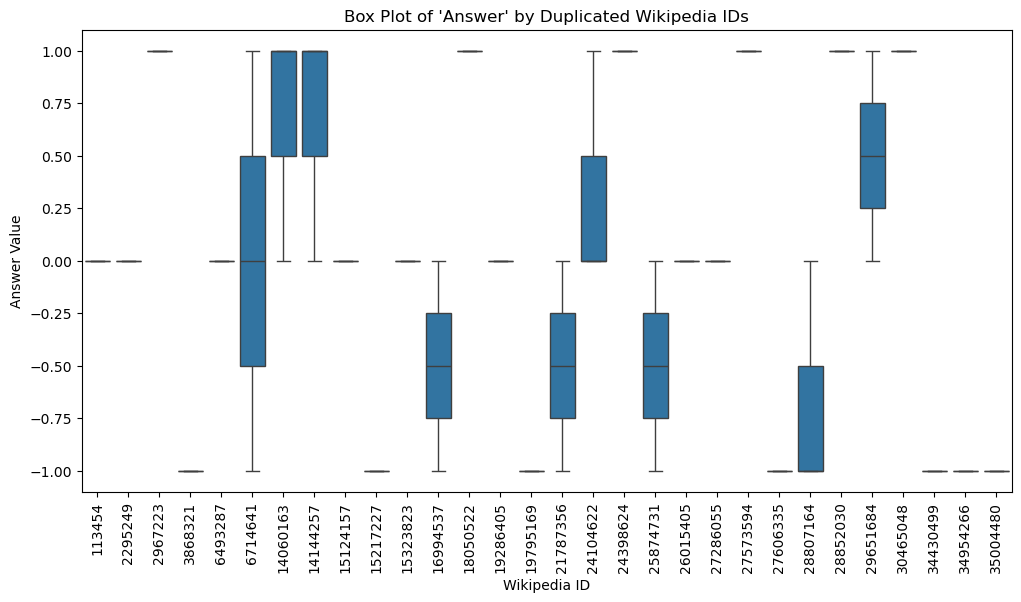

In [5]:
duplicated_data = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [6]:
print("We have",len(ViolentData.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

We have 50 labelled plots
We have 30 duplicated labelling
We have 9 datapoint with different labels


In [8]:
ViolentData = ViolentData.groupby("Wikipedia movie ID").mean()

In [9]:
len(ViolentData.index.intersection(MovieData.index))

16

In [10]:
FinalSet = MovieData.loc[MovieData.index.difference(ViolentData.index)]

In [11]:
TestSet = pd.merge(DataTest,ViolentData["Answer"],left_index=True,right_index=True,how = "inner")

In [12]:
cut = 10
ValidationSet = TestSet[:cut]
TrainingSet = TestSet[cut+1:]

## Regression

In [60]:
#model = Ridge(alpha=6)
#model.fit(TestSet.drop(["Answer"], axis=1), TestSet["Answer"])

model = LinearRegression()  # create the model
model.fit(TestSet.drop(["Answer"], axis=1), TestSet["Answer"])  

#model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
#model.fit(TestSet.drop(["Answer"], axis=1), TestSet["Answer"])

LinearRegression()

In [61]:
print("coefficient",model.coef_)
print("intercept",model.intercept_)
model.score(TestSet.drop(["Answer"], axis=1), TestSet["Answer"])

coefficient [-1.69063917e+06 -1.69063979e+06 -1.69064017e+06 -1.69063939e+06
 -1.69063913e+06 -1.69064031e+06 -1.50719251e-01  5.37588982e-01
 -4.46120731e-04  8.74016574e+00 -8.67996344e+00]
intercept 1690639.3509860865


0.20410667857230214

In [79]:
result = pd.DataFrame(model.predict(ValidationSet.drop(["Answer"], axis=1)),index=ValidationSet.index,columns=["Result"])

def categorize_value(x):
    if x < -1/3:
        return -1
    elif -1/3 <= x <= 1/3:
        return 0
    else:
        return 1

choices = [-1.0, 0.0, 1.0]


result["Answer"] = result["Result"].apply(categorize_value)

In [80]:
result

,Result,Answer
Wikipedia movie ID,,
113454,0.453231,1
2295249,0.238441,0
2967223,0.328193,0
3868321,-0.254575,0
4481850,0.038404,0
5766332,-0.159379,0
6493287,0.069229,0
6714641,0.495859,1
8555713,0.113002,0


In [81]:
ValidationSet["Answer"].to_frame()

,Answer
Wikipedia movie ID,
113454,0.0
2295249,0.0
2967223,1.0
3868321,-1.0
4481850,0.0
5766332,0.0
6493287,0.0
6714641,0.0
8555713,-1.0
